# Writer on AWS Bedrock — Pixtral Large integration

This notebook demonstrates how to invoke **Writer models hosted on Amazon Bedrock** using the **Writer SDK**.

**Model used in the book:**
- `us.mistral.pixtral-large-2502-v1:0`

## Prerequisites

Before running this notebook, ensure you have:

- A [Writer AI Studio](https://app.writer.com/register) account
- A valid **Writer API key**
- [AWS credentials are set up in your account](https://dev.writer.com/home/external-models#manage-credentials).

**Relevant docs:**
- [Writer Bedrock examples](https://github.com/writer/aws-examples/tree/main/bedrock-examples)
- [Writer on Amazon Bedrock (AWS Blog)](https://aws.amazon.com/blogs/aws/writer-palmyra-x5-and-x4-foundation-models-are-now-available-in-amazon-bedrock/)


## Bedrock model setup (Writer UI)

Before invoking models from code, configure Amazon Bedrock as a provider inside the Writer platform. Check more details [here](https://dev.writer.com/home/external-models#how-external-models-work)

### 1. Add model
Use the **Add model** button in the Writer dashboard.

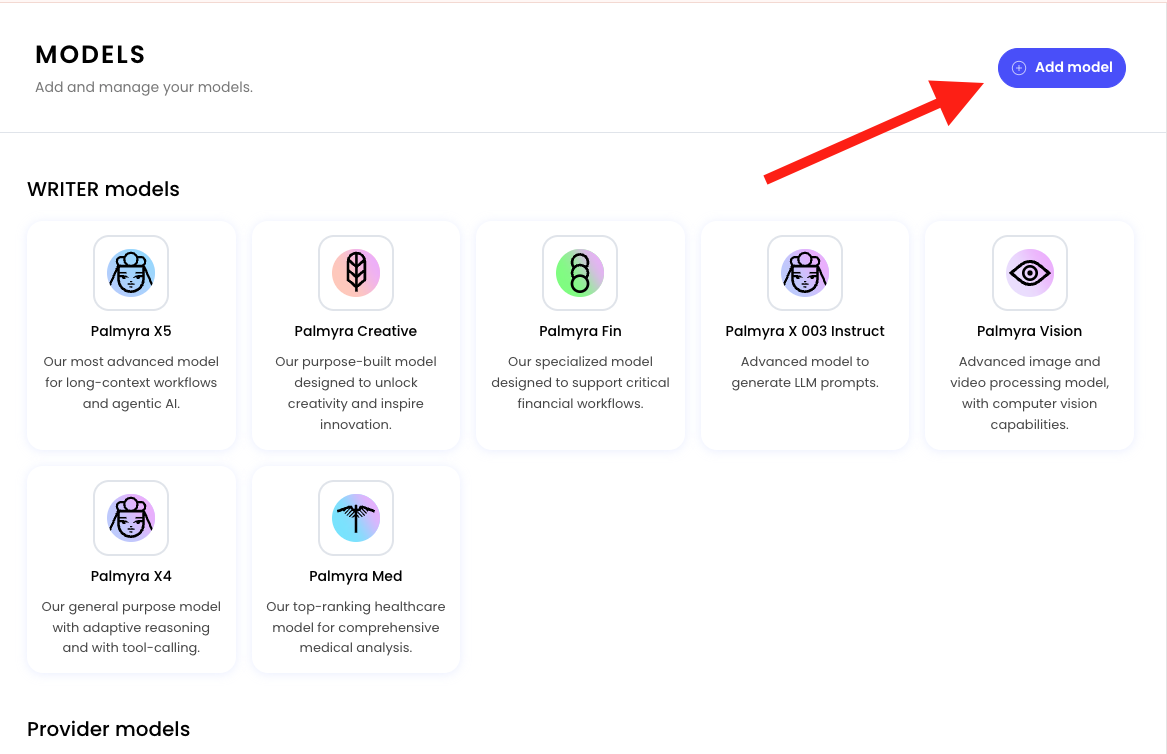

### 2. Choose Amazon Bedrock
Select **Amazon Bedrock** as the provider.

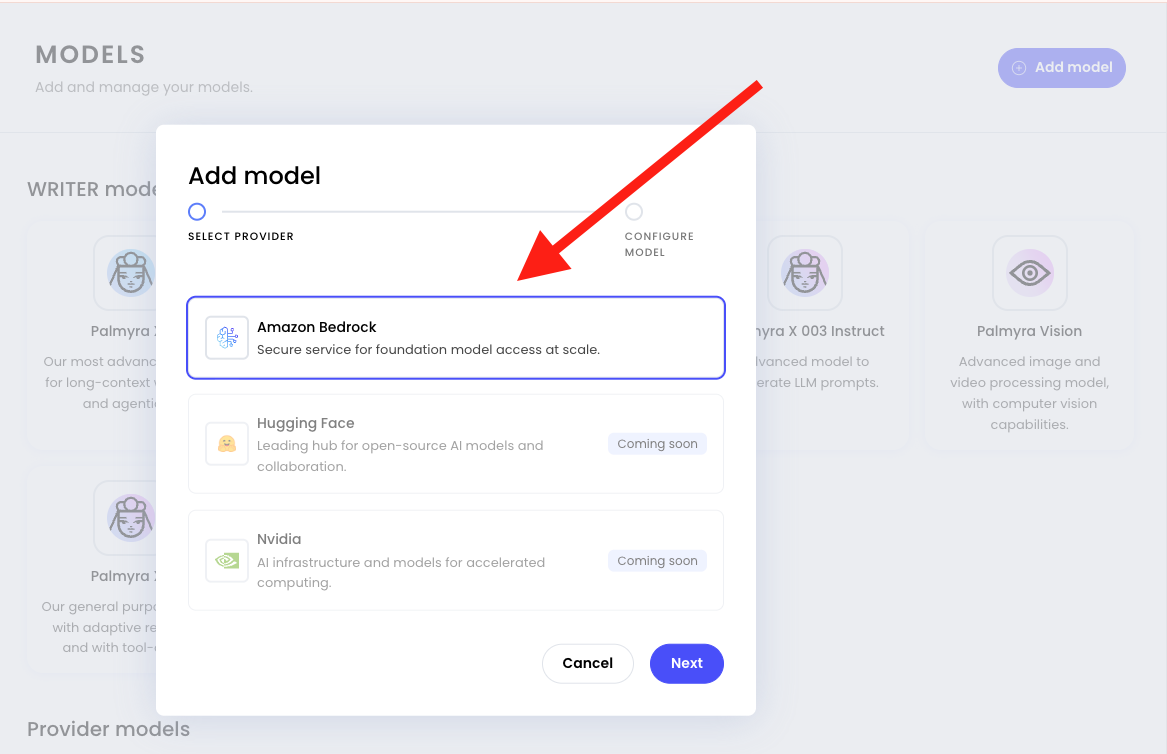

### 3. Configure credentials, model, and team access
Provide:
- AWS credentials
- Model identifier
- Team access permissions

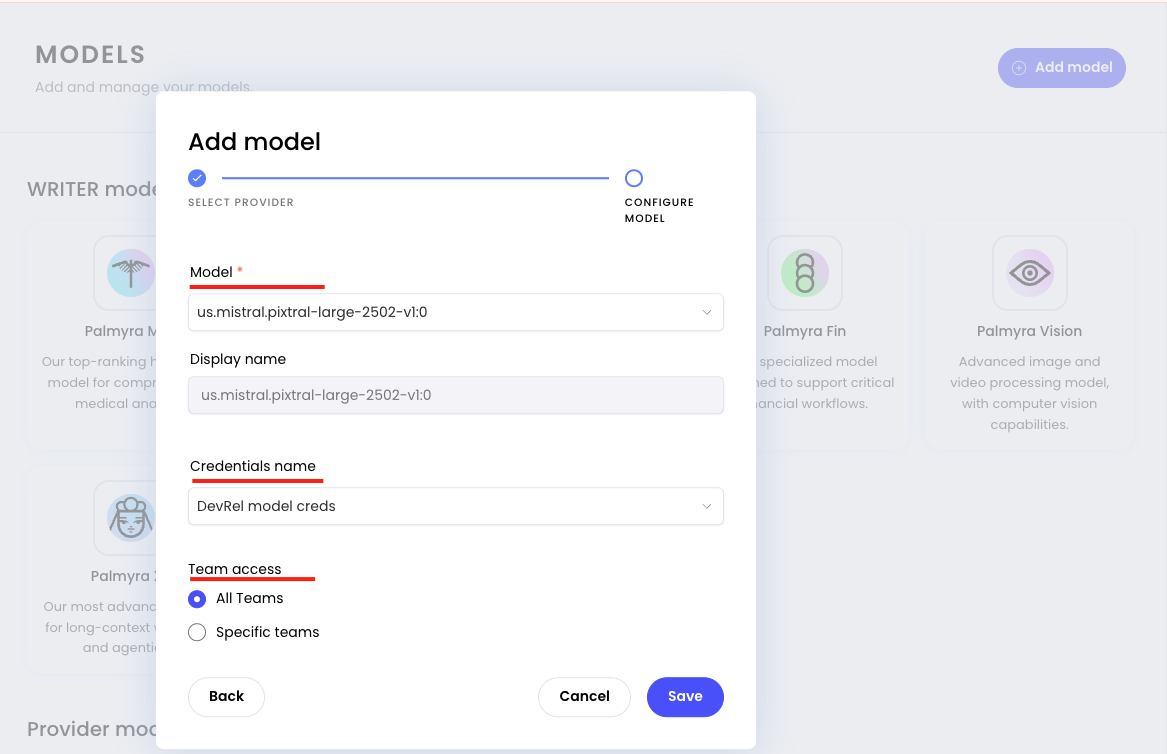

In [ ]:
%pip install -qU writer-sdk

## Environment variables

The Writer SDK uses your Writer API key and AWS credentials to route requests to Amazon Bedrock.

In [1]:
import os
import getpass

if not os.getenv("WRITER_API_KEY"):
    os.environ["WRITER_API_KEY"] = getpass.getpass("Writer API key: ")


Writer API key:  ········


## Basic chat completion

This example sends a standard text-only request to Pixtral Large on Amazon Bedrock.

In [2]:
from writerai import Writer

MODEL_ID = "us.mistral.pixtral-large-2502-v1:0"

client = Writer() 

response = client.chat.chat(
    model=MODEL_ID,
    messages=[
        {"role": "user", "content": "Hello. Could you tell me about yourself - your name and version?"}
    ],
    max_tokens=300
)

print(response.choices[0].message.content)

Hello! I am a text-based AI model. I don't have a personal name or version number like traditional software, but I'm here to assist you with information, answer questions, and provide explanations to the best of my ability. I'm constantly being updated and improved by the Mistral AI team. How can I assist you today?


## Multimodal request (text + image)

Pixtral Large supports multimodal reasoning on Amazon Bedrock.
This request follows the same structure documented in the Writer Bedrock examples.

In [3]:
response = client.chat.chat(
    model=MODEL_ID,
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Analyze the image and summarize key insights."},
                {"type": "image_url", "image_url": "https://assets.science.nasa.gov/dynamicimage/assets/science/cds/general/images/pia00271/PIA00271~large.jpg?w=1920&h=1920&fit=clip&crop=faces%2Cfocalpoint"}
            ]
        }
    ],
    max_tokens=400
)

print(response.choices[0].message.content)

The image depicts the planet Venus as seen from space. The planet appears as a large, nearly featureless yellowish-orange sphere with a thick, continuous cloud cover that obscures the surface details. Venus is known for its dense atmosphere, which is primarily composed of carbon dioxide and sulfuric acid clouds, contributing to its characteristic appearance.

Key insights about Venus include:

1. **Atmosphere**: Venus has the thickest atmosphere of the four terrestrial planets in the Solar System, which is approximately 90 times denser than Earth's.
2. **Cloud Cover**: The dense cloud layer is what gives Venus its uniform, yellowish-orange appearance and hides the surface from view.
3. **Surface Conditions**: Beneath the clouds, Venus has a rocky surface with extreme conditions, including temperatures that can reach up to 870 degrees Fahrenheit (465 degrees Celsius) and atmospheric pressure that is about 92 times that of Earth's.
4. **Rotation**: Venus rotates in the opposite direction

## Using tools (function calling)

This section demonstrates how to expose **Python functions** as tools so that a Writer model
can decide when to invoke them.

We will build a simple transaction agent that:
- Reads a transaction by ID
- Approves a transaction by ID

In [4]:
def send_email_to_user(email, subject, body):
    """Mock sending an email to a user."""
    print(f"Email sent to {email} with subject '{subject}' and body '{body}'")
    return f"Email to {email} was sent successfully."


def get_order_info(order_id):
    """Mock fetching order information."""
    print(f"Fetching info for order ID: {order_id}")
    return {
        "order_id": order_id,
        "status": "Shipped",
        "items": ["Widget A", "Widget B"],
        "total": "$123.45"
    }


### Tool schema definition

Each tool is described using a JSON schema so the model understands:
- Tool name
- Purpose
- Required parameters

In [5]:

tools = [
    {
        "type": "function",
        "function": {
            "name": "send_email_to_user",
            "description": "Send an email to a user",
            "parameters": {
                "type": "object",
                "properties": {
                    "email": {"type": "string", "description": "Email address of the recipient"},
                    "subject": {"type": "string", "description": "Subject of the email"},
                    "body": {"type": "string", "description": "Body of the email"}
                },
                "required": ["email", "subject", "body"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "get_order_info",
            "description": "Get information about an order by ID",
            "parameters": {
                "type": "object",
                "properties": {
                    "order_id": {"type": "string", "description": "The order ID to fetch information for"}
                },
                "required": ["order_id"]
            }
        }
    }
]


### Executing a tool call

The model first decides **which tool to call**.
Your application is responsible for:
1. Executing the tool
2. Appending the tool result back into the conversation
3. Asking the model for a final response

- Executing the tool:

In [6]:
messages = [{"role": "user", "content": "Send an email to test@example.com and get info for order 12345"}]

response = client.chat.chat(
    model=MODEL_ID,
    messages=messages,
    tools=tools,
    tool_choice="auto",
    stream=False
)

response_message = response.choices[0].message
messages.append(response_message)
print(f"Tool call response message object:\n{response_message}\n")



Tool call response message object:
ChatCompletionMessage(content='', refusal=None, role='assistant', graph_data=None, llm_data=None, tool_calls=[ToolCall(id='tooluse_2O93OjLjQL-4gQKY3HEsBw', function=Function(arguments='{"email": "test@example.com", "subject": "Order Information Request", "body": "Dear customer, we have received your request for order information. We will process it shortly and get back to you with the details."}', name='send_email_to_user'), type='function', index=0), ToolCall(id='tooluse_HWu5G0lCSU2RqI6Mn1R1rg', function=Function(arguments='{"order_id": "12345"}', name='get_order_info'), type='function', index=1)], translation_data=None, web_search_data=None, function_call=None)



 - Appending the tool result back into the conversation:

In [7]:
tool_calls = response_message.tool_calls
for tool_call in tool_calls:
    args = eval(tool_call.function.arguments)
    if tool_call.function.name == "send_email_to_user":
        function_response = send_email_to_user(args["email"], args["subject"], args["body"])
    elif tool_call.function.name == "get_order_info":
        function_response = get_order_info(args["order_id"])

    messages.append(
        {
            "role": "tool",
            "tool_call_id": tool_call.id,
            "name": tool_call.function.name,
            "content": str(function_response),
        }
    )


Email sent to test@example.com with subject 'Order Information Request' and body 'Dear customer, we have received your request for order information. We will process it shortly and get back to you with the details.'
Fetching info for order ID: 12345


### Final model response

Once tool results are added, the model can generate a user-facing answer.

- Asking the model for a final response: 

In [8]:
final_response = client.chat.chat(
    model=MODEL_ID,
    messages=messages,
    stream=False
)

print(final_response.choices[0].message.content)

An email has been sent to test@example.com confirming their request for order information.

Here are the details for order 12345:
- Status: Shipped
- Items: Widget A, Widget B
- Total: $123.45


In this notebook demonstrated how to perform an end-to-end integration of `Amazon Bedrock` models using the `Writer SDK`, covering `basic chat`, `multimodal requests`, and `tool-driven` agent workflows within a single setup.